Source: https://github.com/randerson112358/Python/blob/master/LSTM_Stock/LSTM2.ipynb

In [23]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as web

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [25]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [26]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from train_utils import train_model

In [27]:
np.random.seed(1234)
torch.manual_seed(1234)

In [28]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,270.128906
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,270.817261
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,274.498535


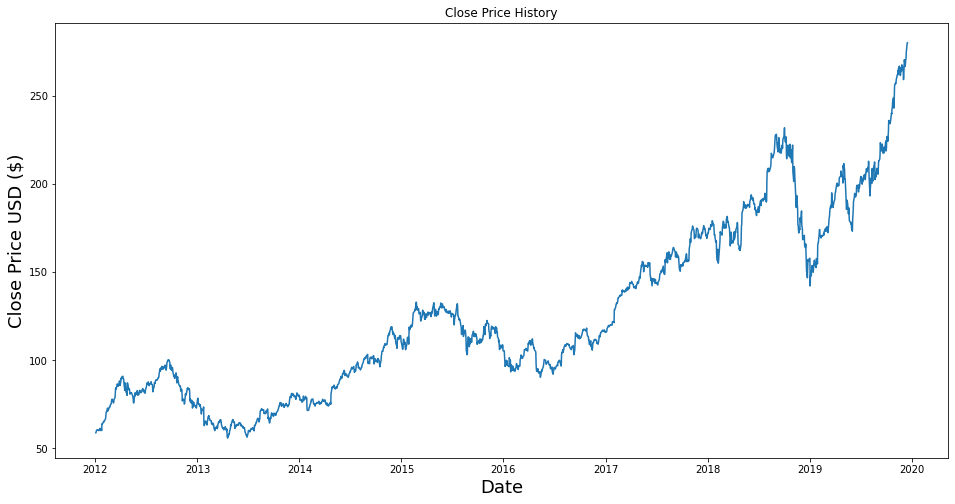

In [29]:
plt.figure(figsize=(16, 8))
plt.title("Close Price History")
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.show()

In [30]:
data = df.filter(["Close"])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1603

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01316509],
       [0.01457064],
       [0.01748985],
       ...,
       [0.97658263],
       [0.99755134],
       [1.        ]])

In [32]:
STEP = 60

In [33]:
train_data = scaled_data[0:training_data_len, :]

x_train = np.array([train_data[i-STEP:i, 0] for i in range(STEP, training_data_len)])
y_train = np.array([train_data[i, 0] for i in range(STEP, training_data_len)])

In [34]:
ENTRY_COUNT = len(y_train)

In [35]:
x_train = x_train.reshape(ENTRY_COUNT, STEP, 1)
x_train.shape

(1543, 60, 1)

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
traindl = torch.utils.data.DataLoader([(x_train[i], y_train[i]) for i in range(len(y_train))], shuffle=True, batch_size=50)
valdl = torch.utils.data.DataLoader([(x_val[i], y_val[i]) for i in range(len(y_val))], shuffle=True, batch_size=50)

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(1, 50, num_layers=2)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)
    
    def regularizer(self):
        return torch.tensor(0.0)
    
    def forward(self, x):
        result, _ = self.rnn(x)
        result = result[-1,:]
        result = self.fc1(result)
        result = self.fc2(result)
        return result, None

In [38]:
net = Net().double()
def criterion(y_pred, _, y):
    return torch.mean((y_pred-y.view(-1,1))**2)

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [39]:
net = train_model(net, traindl, valdl, criterion, optimizer, "stock-predict.pt")

[1, 100.00%] train loss: 0.024800
[1, 100.00%] validate loss: 0.022324
[2, 100.00%] train loss: 0.018860
[2, 100.00%] validate loss: 0.018936
[3, 100.00%] train loss: 0.009010
[3, 100.00%] validate loss: 0.002805
[4, 100.00%] train loss: 0.001643
[4, 100.00%] validate loss: 0.000805
[5, 100.00%] train loss: 0.000573
[5, 100.00%] validate loss: 0.000543
[6, 100.00%] train loss: 0.000352
[6, 100.00%] validate loss: 0.000396
[7, 100.00%] train loss: 0.000345
[7, 100.00%] validate loss: 0.000455
Retry 1/5
[8, 100.00%] train loss: 0.000310
[8, 100.00%] validate loss: 0.000392
[9, 100.00%] train loss: 0.000304
[9, 100.00%] validate loss: 0.000398
Retry 1/5
[10, 100.00%] train loss: 0.000299
[10, 100.00%] validate loss: 0.000382
[11, 100.00%] train loss: 0.000293
[11, 100.00%] validate loss: 0.000362
[12, 100.00%] train loss: 0.000308
[12, 100.00%] validate loss: 0.000363
Retry 1/5
[13, 100.00%] train loss: 0.000323
[13, 100.00%] validate loss: 0.000327
[14, 100.00%] train loss: 0.000274
[14,

In [40]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = torch.tensor([test_data[i-60:i, 0] for i in range(60, len(test_data))])
y_test = dataset[training_data_len:,:]
x_test = x_test.reshape(len(x_test), STEP, 1)

In [41]:
predictions, _ = net(x_test.transpose(1, 0))
predictions = scaler.inverse_transform(predictions.data.numpy())

In [42]:
rmse = np.sqrt(np.mean((predictions-y_test)**2))
rmse

8.122978464215054

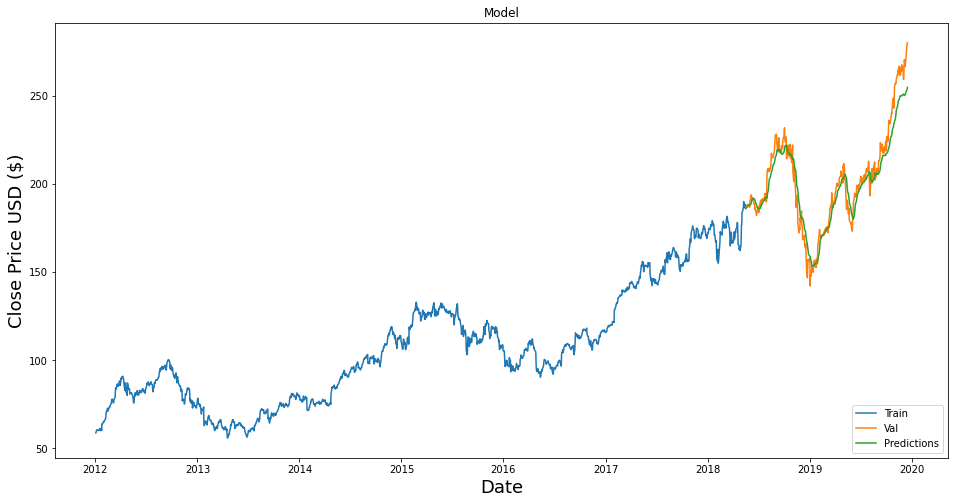

In [45]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid.insert(1,"Predictions",predictions)

plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [44]:
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,186.077306
2018-05-18,186.309998,186.565267
2018-05-21,187.630005,186.823863
2018-05-22,187.160004,187.069453
2018-05-23,188.360001,187.245446
...,...,...
2019-12-11,270.769989,251.716494
2019-12-12,271.459991,252.294910
2019-12-13,275.149994,252.921021
